# Notebook to generate a simple report of current trends in acoustic related jobs

## First we import the libraries and the dataset

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [18]:
# You need to define somewhere which identifiers are actually programming languages
programming_languages = set(['python','matlab','c++','c','java',
'c#','rust','go','R'])
skills_that_need_programming = set(['dsp','machine_learning','signal_processing','programming','deep_learning'])
programming_languages_or_skills_that_need_programming = programming_languages.union(skills_that_need_programming)

df = pd.read_excel('vagas_dataset.xlsx')
df.head()


,job_title,main_field,is_in_industry,technical_skills,soft_skills,needed_experience
0,phd,voice;speech,no,signal_processing;deep_learning;python;linux;m...,autonomy;creativity;communication;good_program...,phd
1,research_engineer,vr;virtual_acoustics,yes,c;c++;python;signal_processing;dsp,communication;teamwork;autonomy,master
2,support_engineer,nvh,yes,acoustic;vibration;matlab;python;ms_office,communication;teamwork;autonomy,bachelor
3,phd,voice;speech;hearing_aid,no,dsp;machine_learning;signal_processing,communication;teamwork;good_programming_style,phd
4,phd,acoustic_scene_detection,no,signal_processing;statistics;machine_learning,passion,master


Here we parse the dataset so we can obtain useful information of it

In [19]:
## define a function to sort a dictionary by its values
def sort_dict(d):
    return dict( sorted(d.items(), key=lambda x: x[1], reverse=True) )

def add_value_to_dict(d, key):
    if key in d:
        d[key] += 1
    else:
        d[key] = 1
    return d

def update_dictionary(dictionary_to_update, df_list):
    current_values = df_list.split(';')
    current_values = rename_words(current_values)
    for field in current_values:
        add_value_to_dict(dictionary_to_update,field)
    return dictionary_to_update

def rename_words(list_to_update):
    replace_tuples = [('acoustics','technical_acoustics'),
                       ('vibration','structure_dynamics'),
                       ('-','none specified')]
    for word_pair in replace_tuples:
        if word_pair[0] in list_to_update:
            list_to_update[list_to_update.index(word_pair[0])] = word_pair[1]
    return list_to_update 
    
number_of_jobs_with_programming_languages = 0
results_dictionary = dict()
results_dictionary_industry = dict() 
results_dictionary_academia = dict()
colums = df.columns
for column in colums:
    results_dictionary[column] = dict()
    results_dictionary_academia[column] = dict()
    results_dictionary_industry[column] = dict()

for job in range(len(df)):
    for column in colums:
        results_dictionary[column] = update_dictionary(results_dictionary[column], df[column][job])

        if df['is_in_industry'][job] == 'yes':
            results_dictionary_industry[column] = update_dictionary(results_dictionary_industry[column], df[column][job])
        else:
            results_dictionary_academia[column] = update_dictionary(results_dictionary_academia[column], df[column][job])
    number_of_jobs_with_programming_languages += int( sum( val in programming_languages_or_skills_that_need_programming for val in df['technical_skills'][job].split(';') )>0 )

for column in colums:
    results_dictionary[column] = sort_dict(results_dictionary[column])
    results_dictionary_industry[column] = sort_dict(results_dictionary_industry[column])
    results_dictionary_academia[column] = sort_dict(results_dictionary_academia[column])

number_of_industry_jobs = sum( [val for val in results_dictionary_industry[colums[0]].values() ] )
number_of_academia_jobs = sum( [val for val in results_dictionary_academia[colums[0]].values() ] )

print('Number of industry jobs: ', number_of_industry_jobs)
print('Number of academia jobs: ', number_of_academia_jobs)
print('Number of jobs with programming languages: ', number_of_jobs_with_programming_languages)
print('Ratio of jobs with programming languages: ', number_of_jobs_with_programming_languages/(number_of_academia_jobs+number_of_industry_jobs))

Number of industry jobs:  17
Number of academia jobs:  12
Number of jobs with programming languages:  25
Ratio of jobs with programming languages:  0.8620689655172413


Now we define some helper functions as well as define plot properties

In [5]:
title_font_size = 22
labels_font_size = 18
legend_font_size = 15

total_number_of_vacancies = len(df)

def get_top_values_from_column(column:str,top_n:int,plot=False):
    if plot:
        print( 'General: ', list( results_dictionary[column].values() )[:top_n] )
        print( 'Industry: ', list( results_dictionary_industry[column].values())[:top_n] )
        print( 'Academia: ', list( results_dictionary_academia[column].values())[:top_n] )
    return ( list(results_dictionary[column].keys())[:top_n],list(results_dictionary_industry[column].keys())[:top_n],list(results_dictionary_academia[column].keys())[:top_n])


def pre_process_names(names):
    for (idx,name) in enumerate(names):
        name = name.replace('_',' ')
        # Make the first letter of the string uppercase
        name = name[0].upper() + name[1:]
        names[idx] = name
    return names 

def plot_results(plot_title:str,global_skills:list,labels:list,industry_skills:list=None):
    f, ax = plt.subplots(figsize=(8, 6))

    x_indices = np.array(range(len(global_skills)))
    # Plot the total of skills
    plt.barh(  x_indices, global_skills[::-1]/total_number_of_vacancies*100 ,color='#5576a1')
    if industry_skills is not None:
        plt.barh(  x_indices, industry_skills[::-1]/total_number_of_vacancies*100 , color='#bacde6')
    plt.yticks( range(len(global_skills)), pre_process_names(labels[::-1]), rotation=0 ,fontsize=labels_font_size)
    plt.xticks(fontsize=labels_font_size)
    plt.xlabel('Porcentagem das vagas %',fontsize=labels_font_size)
    if industry_skills is not None:
        plt.legend(['Indústria + Academia','Indústria'],fontsize=legend_font_size)
    plt.title(plot_title,fontsize=title_font_size)
    plt.tight_layout()
    plt.savefig(plot_title+'.png', dpi = 300)
    plt.show()
    

def get_value_from_dict_with_zero_fallback(dict,keys):
    return np.array( [dict[key] if key in dict else 0 for key in keys] )

## Lets get the top soft skills listed on the jobs

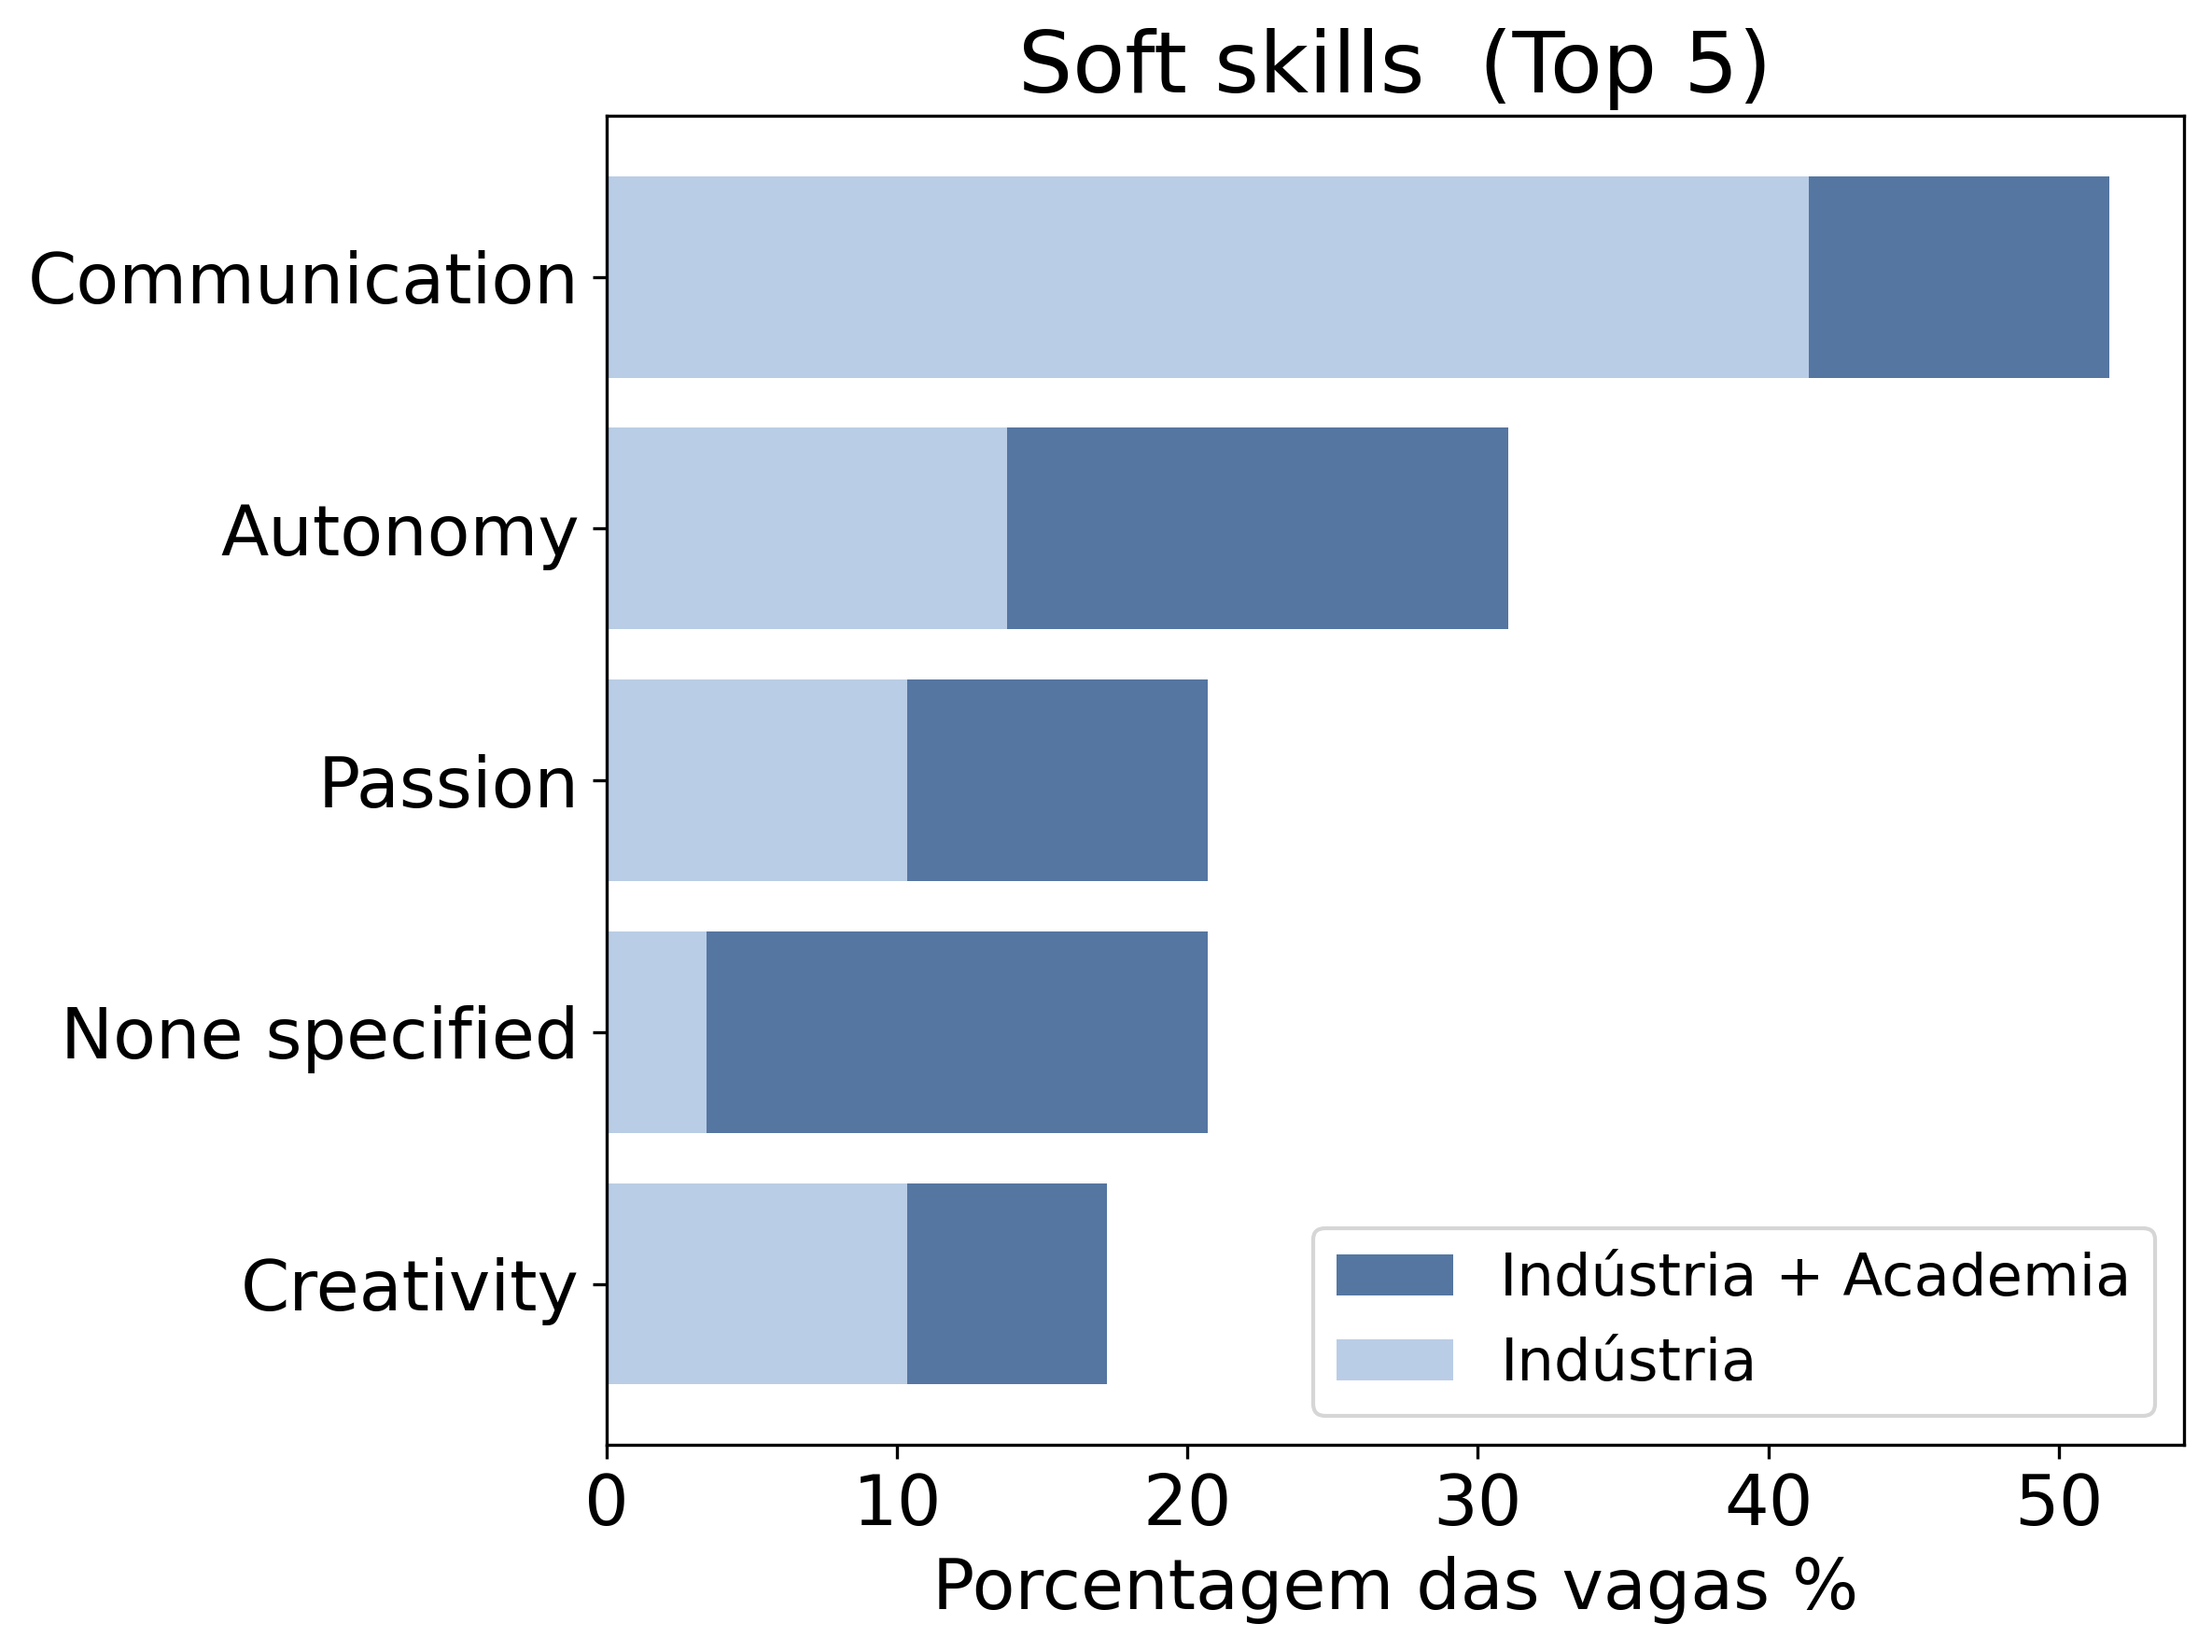

In [6]:
# Initialize the matplotlib figure

number_of_skills = 5
column_name = 'soft_skills'
best_technical_skills ,_,_ = get_top_values_from_column(column_name,top_n=number_of_skills,plot=False)

global_skills = np.array( [results_dictionary[column_name][val] for val in best_technical_skills] )
industry_skills =np.array( [results_dictionary_industry[column_name][val] for val in best_technical_skills] )

plot_results('Soft skills  (Top '+ str(len(global_skills)) +')',
             global_skills,best_technical_skills,industry_skills)

## What are the requirements to get the job (without programming)

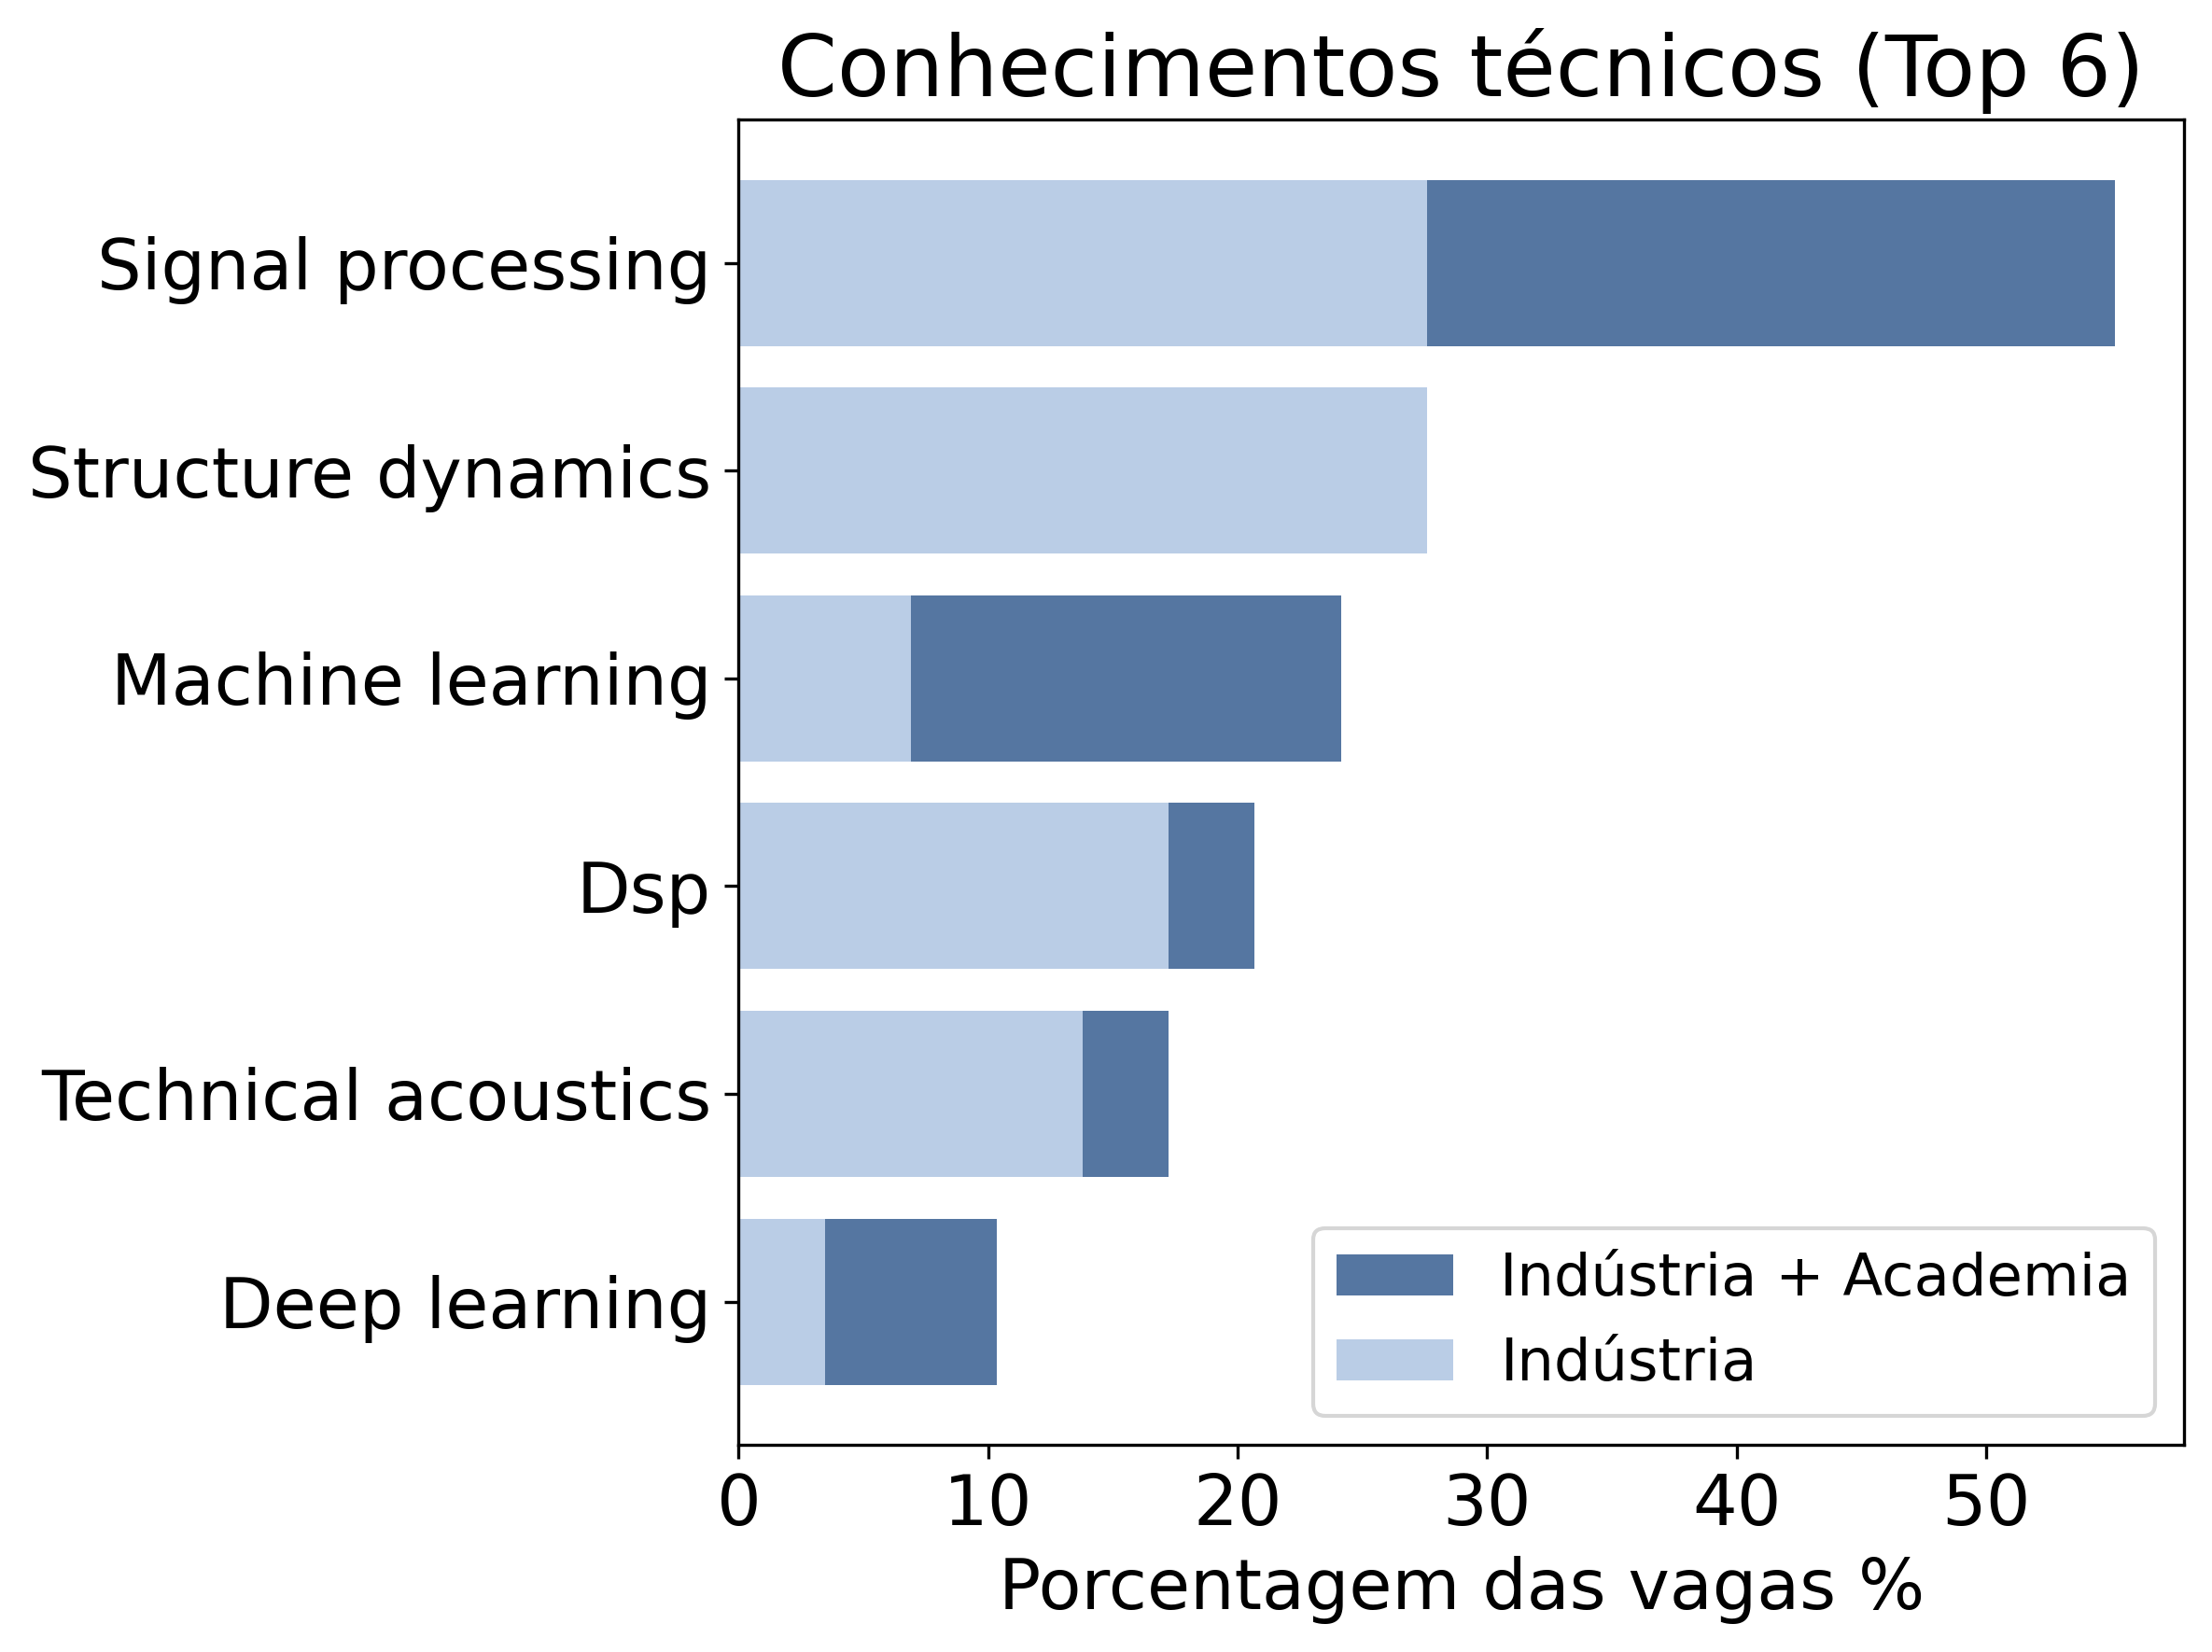

In [7]:
# Initialize the matplotlib figure

number_of_skills = 9
column_name = 'technical_skills'
best_technical_skills ,_,_ = get_top_values_from_column(column_name,top_n=number_of_skills,plot=False)

best_technical_skills_no_coding = [val for val in best_technical_skills if val not in programming_languages]

global_skills = np.array( [results_dictionary[column_name][val] for val in best_technical_skills_no_coding] )
industry_skills =np.array( [results_dictionary_industry[column_name][val] for val in best_technical_skills_no_coding] )

plot_results('Conhecimentos técnicos (Top '+ str(len(global_skills)) +')',
             global_skills,best_technical_skills_no_coding,industry_skills)

## Now only programming :) 

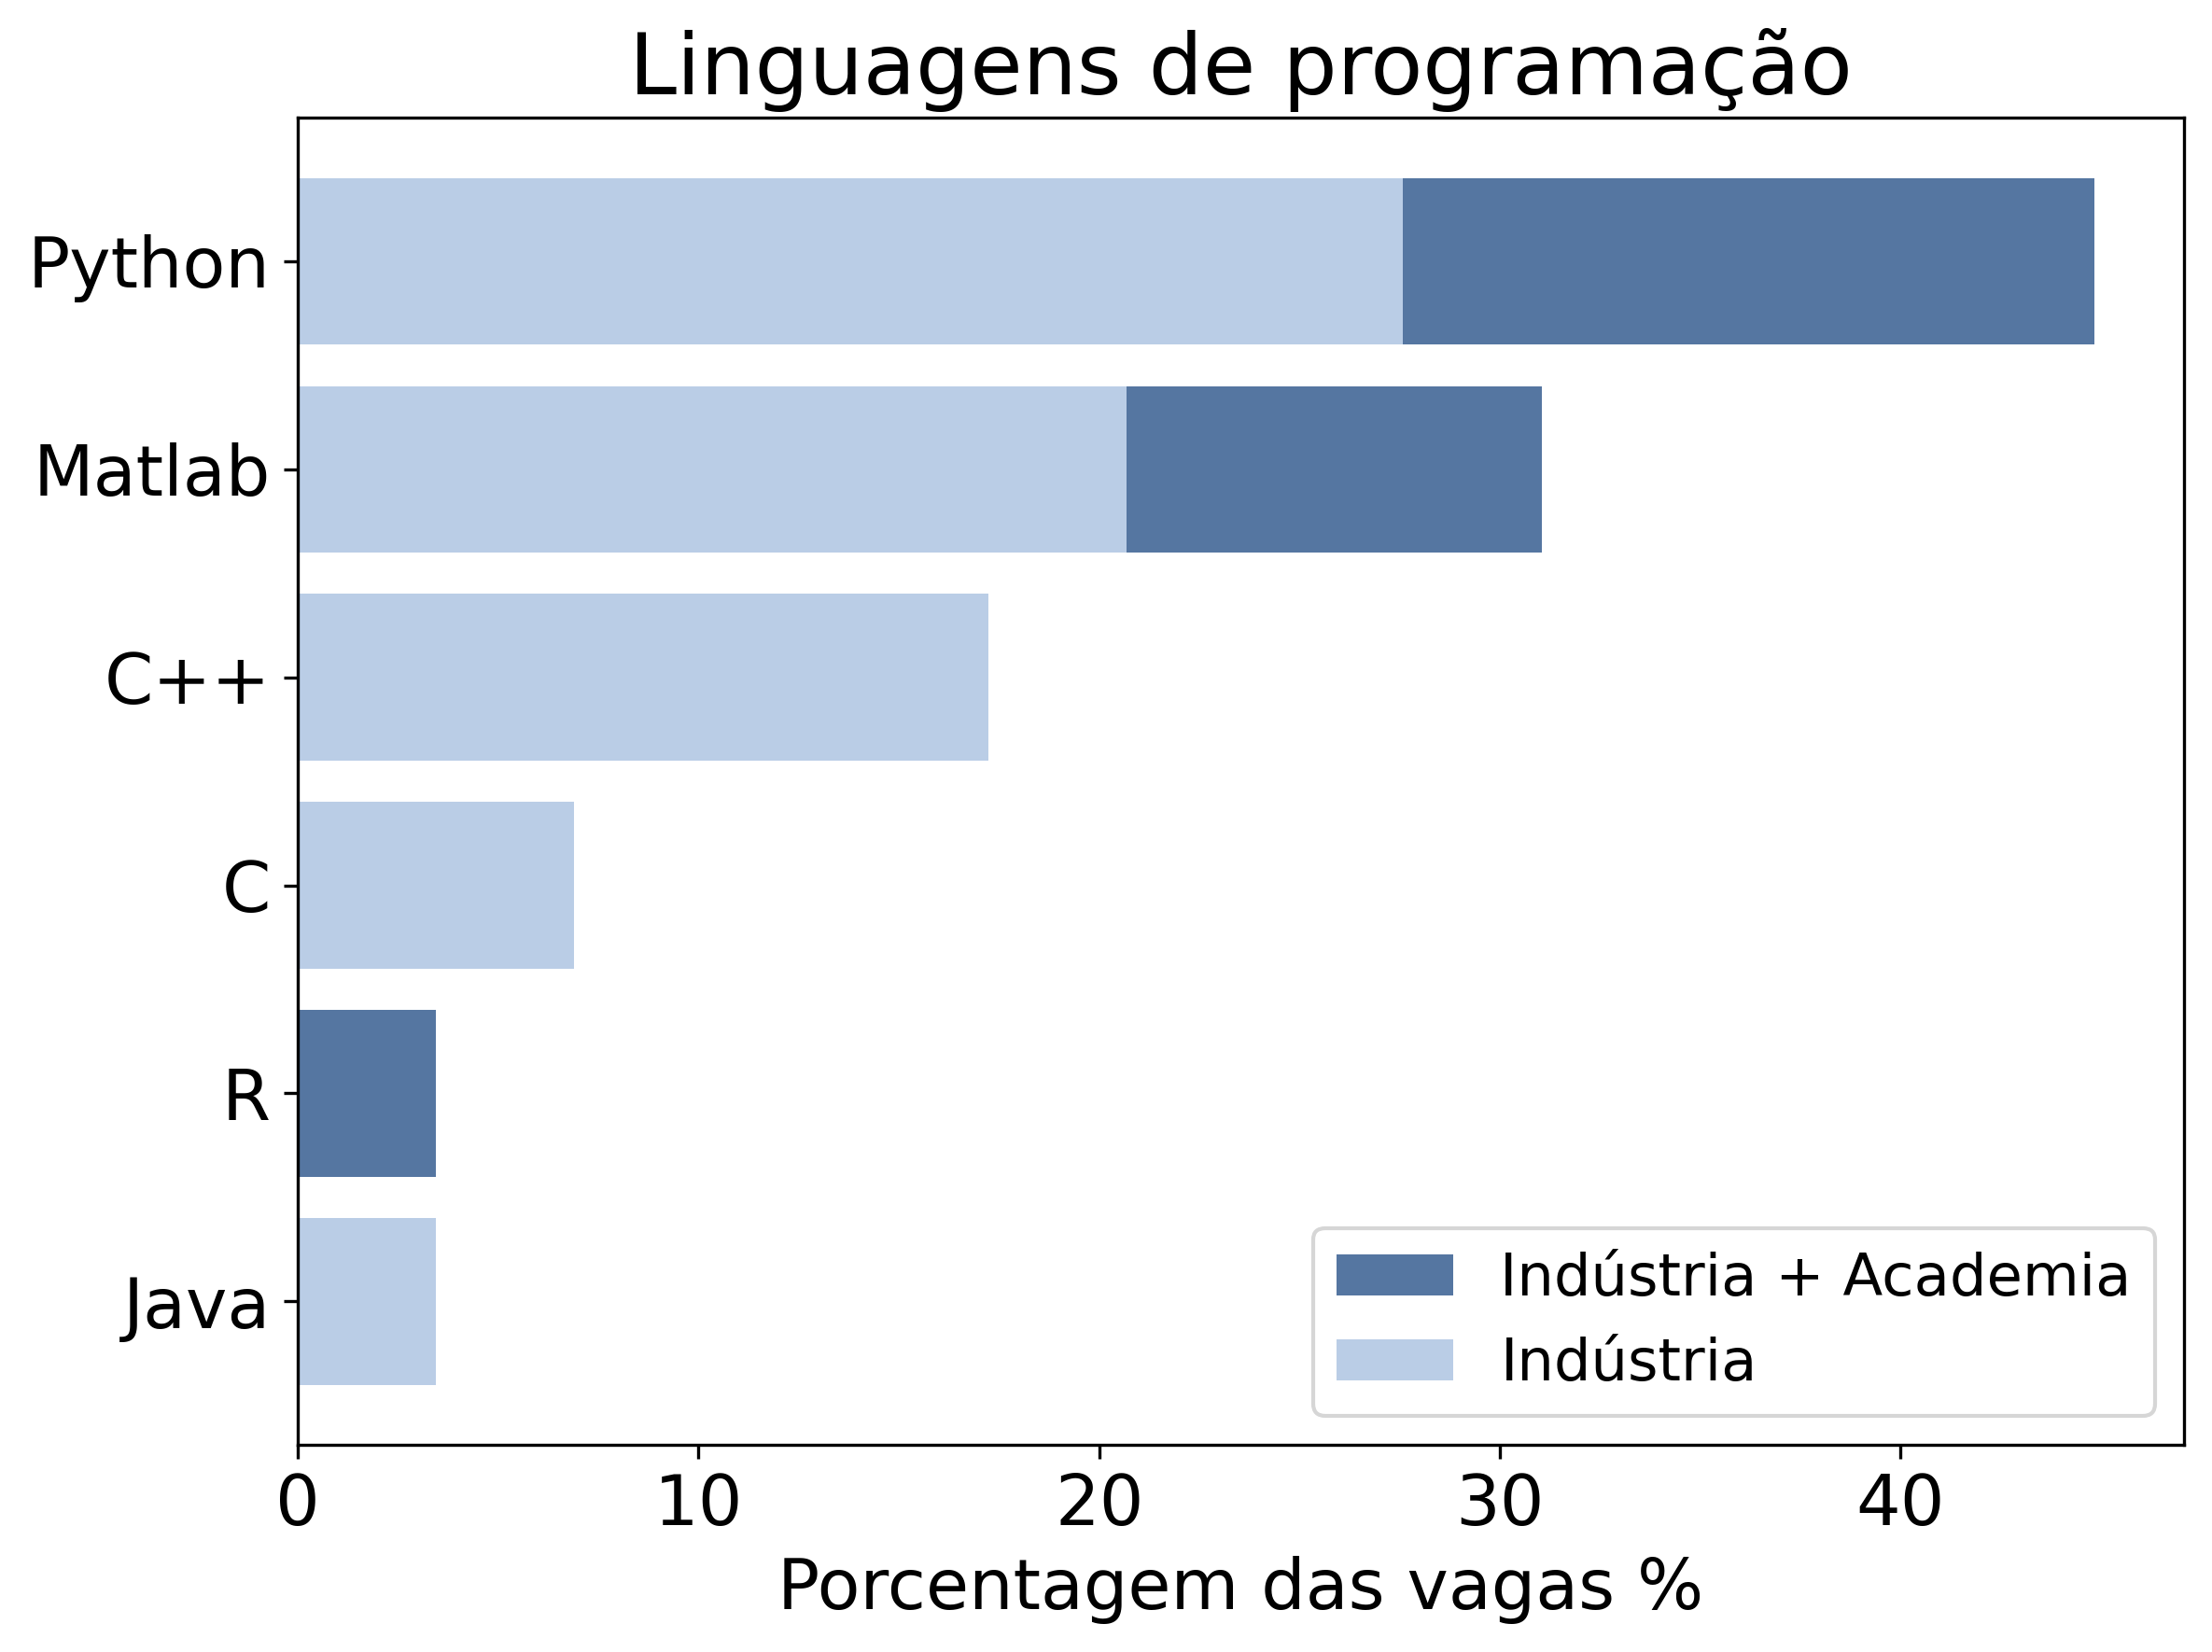

In [8]:
# Initialize the matplotlib figure

column_name = 'technical_skills'
best_technical_skills = [key for key in results_dictionary[column_name].keys() if key in programming_languages]

global_skills = get_value_from_dict_with_zero_fallback(results_dictionary[column_name],best_technical_skills )
industry_skills =get_value_from_dict_with_zero_fallback(results_dictionary_industry[column_name],best_technical_skills )

global_skills = np.array(global_skills)
industry_skills = np.array(industry_skills)

plot_results('Linguagens de programação',
             global_skills,best_technical_skills,industry_skills)

## What job titles are available?

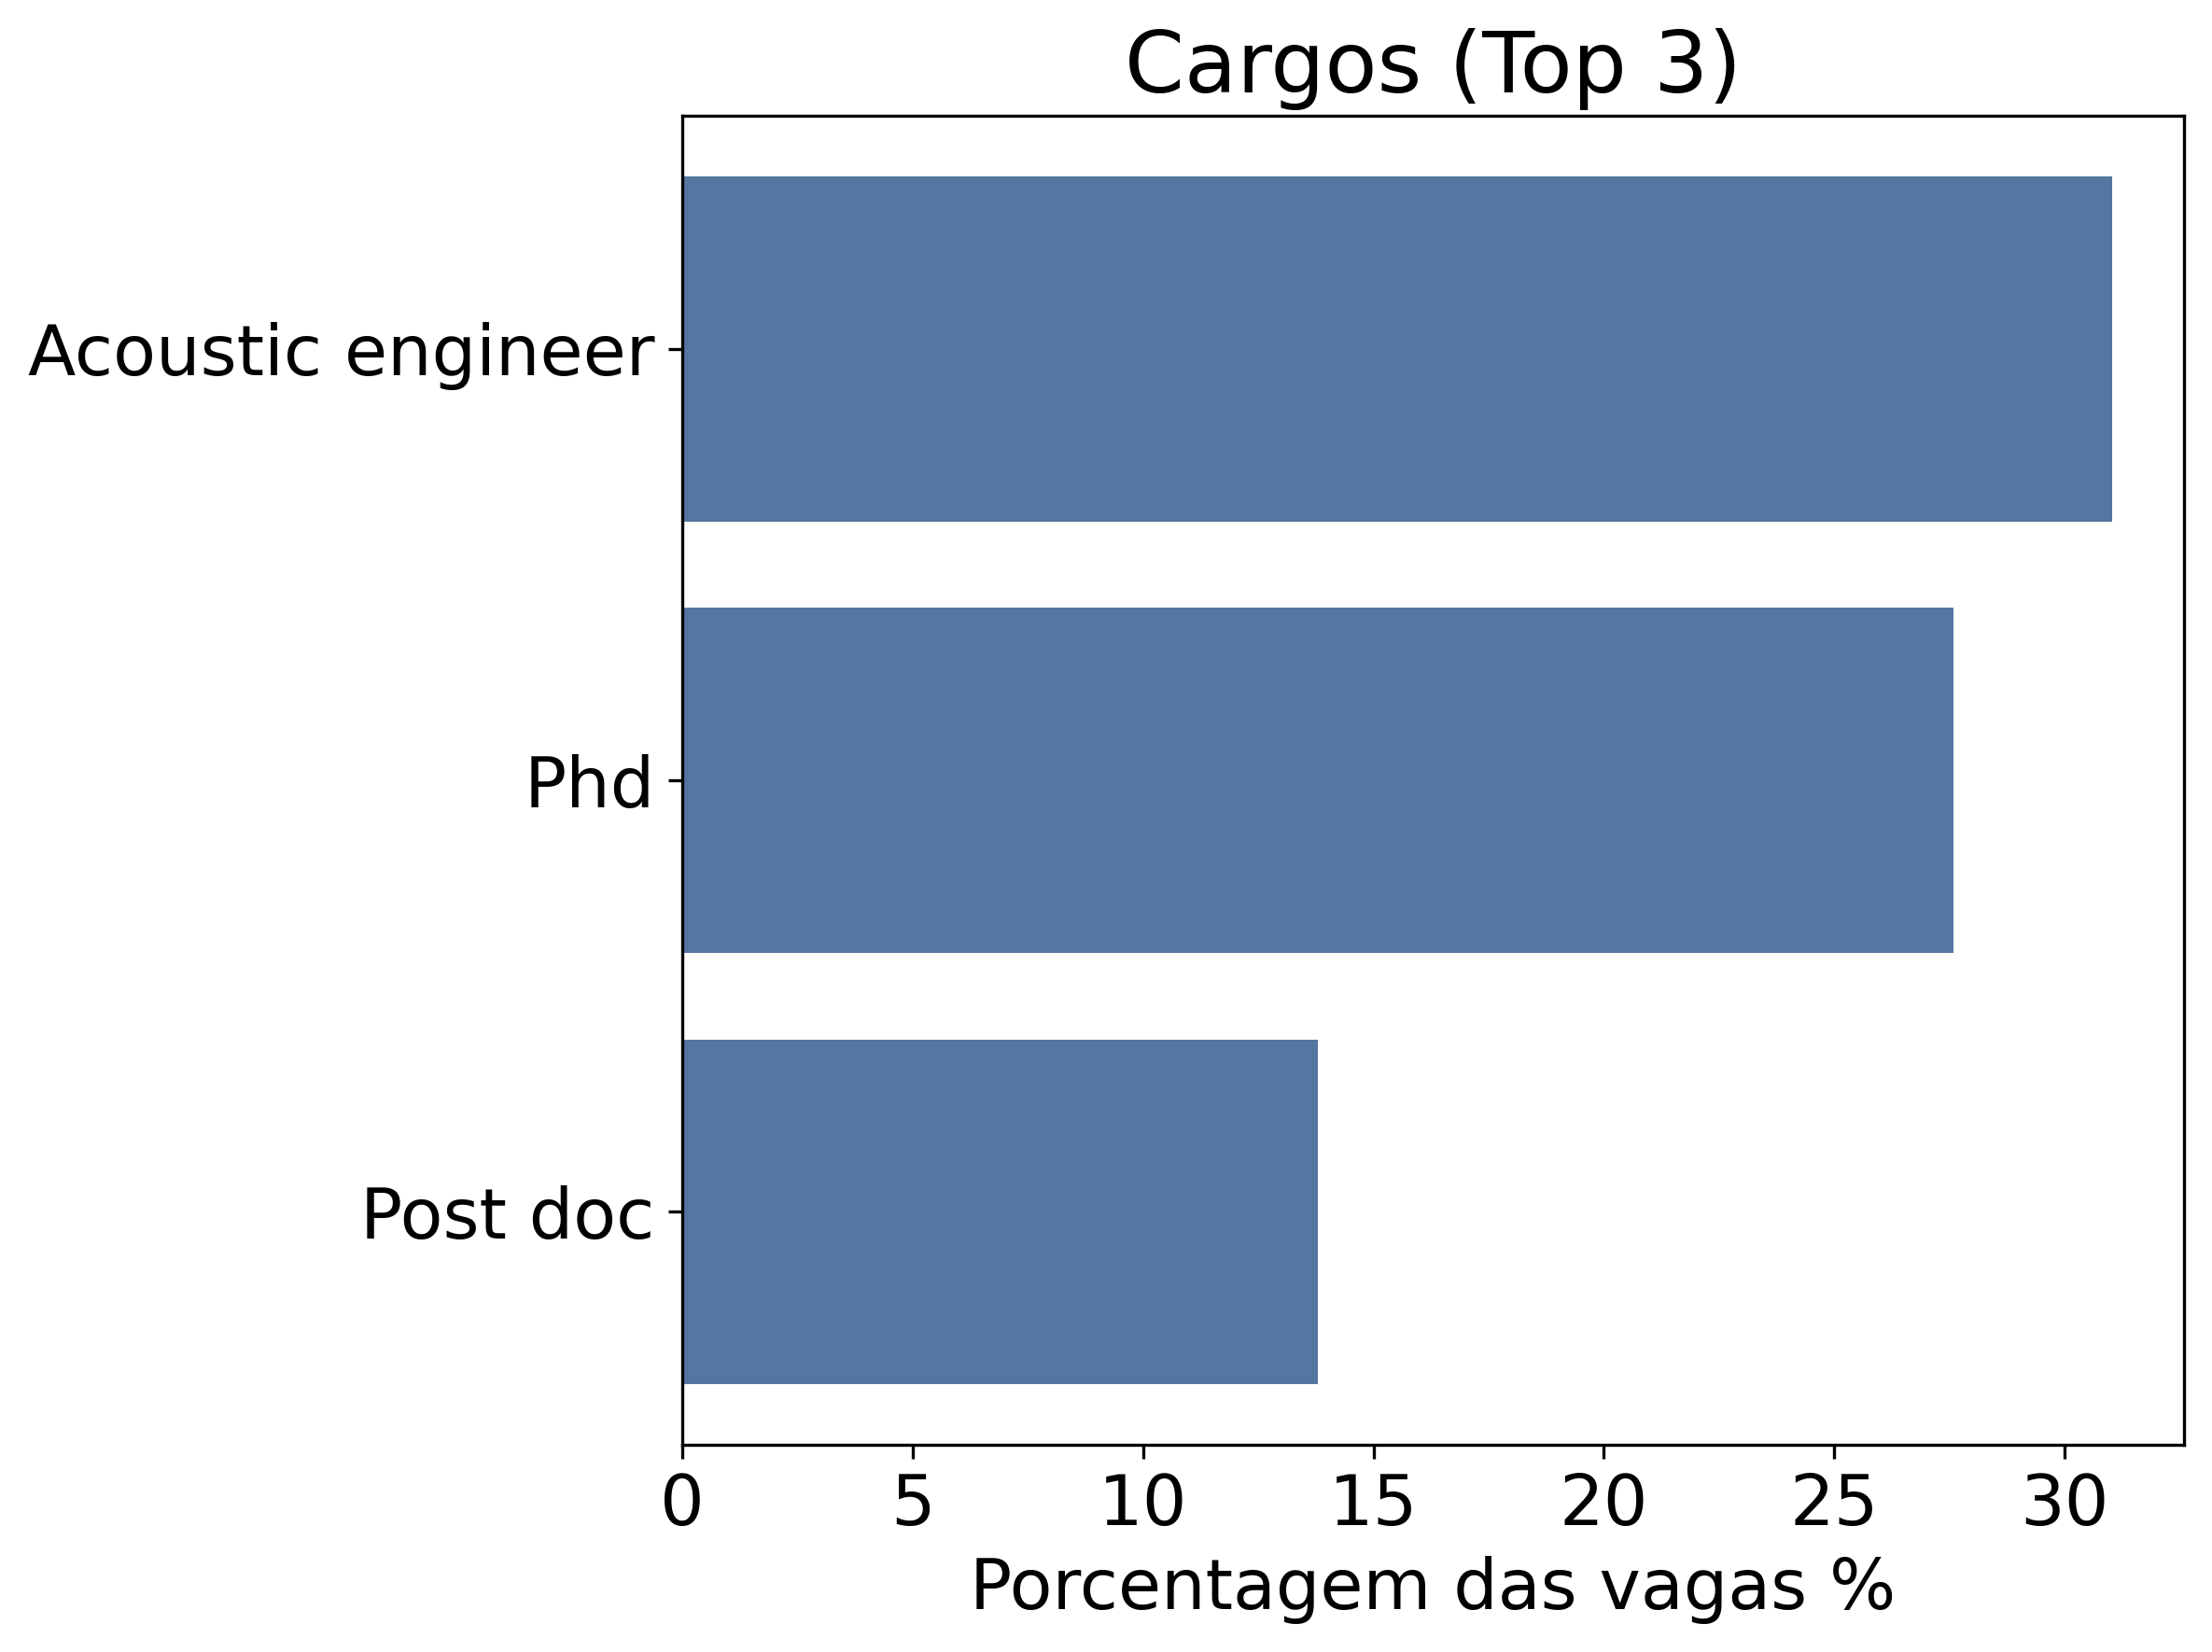

Total de vagas:  72.41379310344827


In [17]:
# Initialize the matplotlib figure

top_n = 3
column_name = 'job_title'
best_technical_skills ,_,_ = get_top_values_from_column(column_name,top_n=top_n,plot=False)

global_skills = np.array( [results_dictionary[column_name][val] for val in best_technical_skills] )

plot_results('Cargos (Top '+str(top_n)+')',
             global_skills,best_technical_skills)

total_percent_of_vacancies = np.sum( global_skills/total_number_of_vacancies*100 )
print('Total de vagas: ',total_percent_of_vacancies)

## Which level of education do you need?

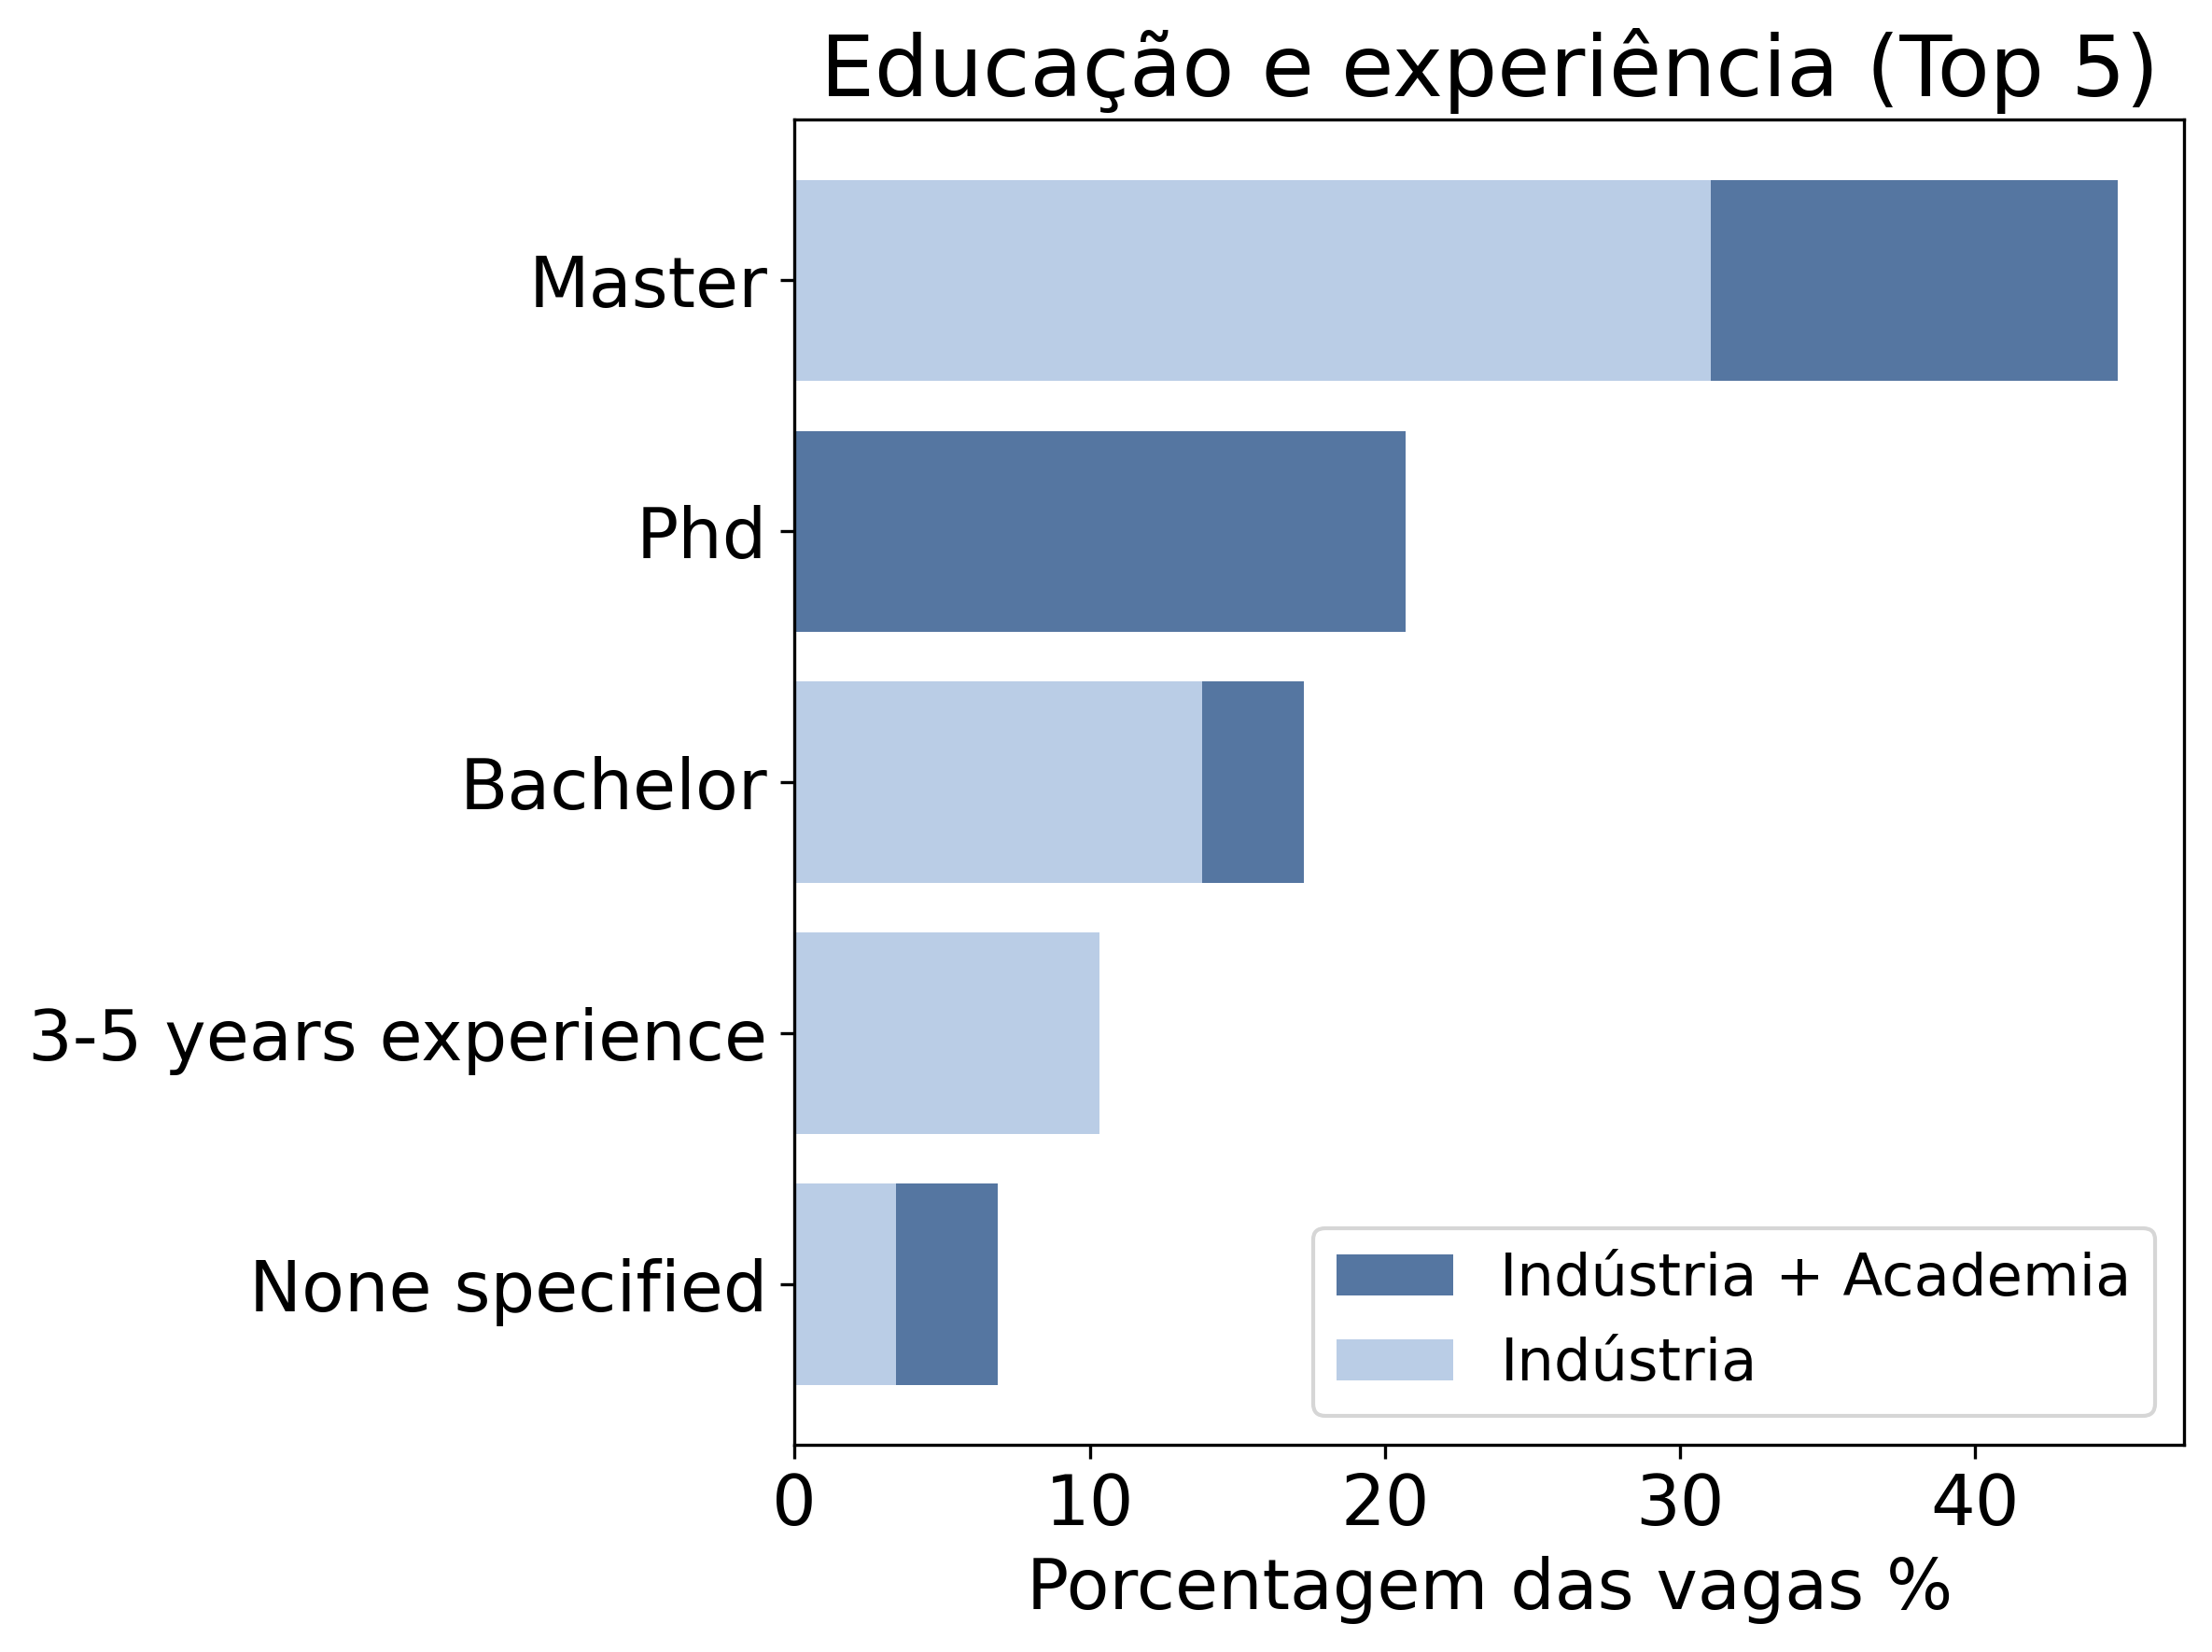

In [10]:
# Initialize the matplotlib figure
column_name = 'needed_experience'
top_n = 5
best_technical_skills ,_,_ = get_top_values_from_column(column_name,top_n=top_n,plot=False)



global_skills = get_value_from_dict_with_zero_fallback(results_dictionary[column_name],best_technical_skills )
industry_skills =get_value_from_dict_with_zero_fallback(results_dictionary_industry[column_name],best_technical_skills )

global_skills = np.array(global_skills)
industry_skills = np.array(industry_skills)

plot_results('Educação e experiência (Top '+str(top_n)+')',
             global_skills,best_technical_skills,industry_skills)